# Prévalence du Listeria dans le lait cru

In [1]:
!ls

README.md                 listeria.txt              projets2021.pdf
exploratoire_claire.ipynb mcmc.ipynb


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random as rd

In [3]:
data = pd.read_csv('listeria.txt', sep=',')
data.columns = ['nb_pos', 'nb_test']
new_row = {'nb_pos':0, 'nb_test':600}
data = data.append(new_row, ignore_index=True)

In [4]:
data['prob']=data["nb_pos"]/data['nb_test']
proba_constante = sum(data['nb_pos'])/sum(data['nb_test'])

In [5]:
proba_constante

0.0010564383073439964

# Question 1 : détermination de la loi a posteriori

On suppose dans un premier temps que la probabilité de présence de listeria dans toutes les études est constante $p$. 


Modèle binomial : $r_i \sim \mathcal{B}(n_i,p)$ de fdr $f(r_i, p) = p^r_i (1-p)^{n_i-r_i}$ 

Loi a priori : $p \sim \mathcal{B}eta(\alpha,\beta)$ avec $\alpha, \beta = 1$ ce qui revient à avoir $p \propto \mathcal{U}([0,1])$ 

Loi a posteriori : $\pi(p|r_1,\dots, r_n) \propto \prod_i^n f(r_i,p) \mathbb{1}_{[0,1]}(r_i) \propto \prod_i^n p^{r_i} (1-p)^{n_i-r_i} \propto  p^{(\sum_i^n r_i+1)-1} (1-p)^{(\sum_i^n n_i-r_i +1)-1} \sim \mathcal{B}eta(\sum_i^n r_i+1, \sum_i^n n_i-r_i+1)$

In [6]:
donnees = []

<AxesSubplot:xlabel='prob', ylabel='Count'>

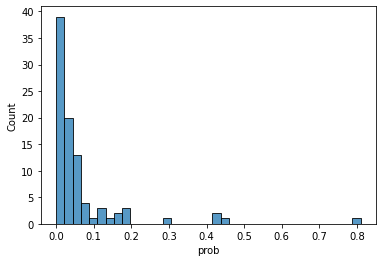

In [7]:
sns.histplot(data, x="prob")

### Loi exponentielle 



In [8]:
def gen_exp(theta):
    u = rd.random()
    return -1/theta*np.log(1-u)

### Loi Gamma 
Remarque : sommer les cas/les études pour un gros échantillon
Simuler une loi beta(alpha, beta) à l'aide de simulation de lois gammas. 

------------
Soient $X$ et $Y$ deux variables independantes distribuees suivant des lois  $\Gamma(a,1)$ et $\Gamma(b,1)$

Alors $U = X+Y$ et $V = X/(X+Y)$ sont deux variables independantes distribuees suivant des lois $\Gamma(a+b,1)$ et $\mathcal{B}eta(a,b)$.





In [9]:
def gamma(x):
    l = [gen_exp(x) for i in range(1000)]
    return mean(l)
        
def f(x, a, b):
    return b**a*x**(a-1)*exp(-bx)/gamma(a)


In [10]:
def gen_gamma(a,b):
    # si alpha = 1, cela revient à avoir une loi exponentielle de paramètre beta
    if a == 1:
        return gen_exp(b)
    # si alpha est un entier non nul, gamma coïncide avec une somme de alpha va exponentielles
    # de paramètre beta indépendantes
    elif a == int(a) and a > 1 : 
        return sum([gen_exp(b) for i in range(a)])
    # sinon, on va utiliser une méthode de rejet 
    else : 
        while True : 
            # on va utiliser une loi de gamma de paramètres entiers pour g
            x = gen_gamma(int(a), b+1)
            # constante calculée dans la photo sur messenger
            c = b**a/((b+1)**int(a))*gamma(int(a))/gamma(a)*(a-int(a))**(a-int(a))*exp(-int(a)+a)
            u = rd.random()
            if u <= c*f(x, a, b)/g(x, int(a), b+1):
                return x 
        
        

In [11]:
def gen_beta(alpha, beta):
    X = gen_gamma(alpha, 1)
    Y = gen_gamma(beta,1)
    return X/(X+Y)

In [13]:
def gen_bernoulli(p):
    if rd.random() <= p :
        return 1
    return 0

In [12]:
def gen_binomiale(n,p):
    return sum([gen_bernoulli(p) for i in range(n)])


Représentation graphique 


Loi a posteriori : $\pi(p|r_1,\dots,r_n) \sim \mathcal{B}eta(\sum_i^n r_i+1, \sum_i^n n_i-r_i+1)$

In [45]:
list_n = data['nb_test'].tolist()
r_list = []
for elem in list_n:
    r_list.append(gen_binomiale(elem,proba_constante)) 
R = sum(r_list)+1
N = sum(list_n)-sum(r_list)+1 
R,N

(1326, 1255730)

In [58]:
distr = [gen_beta(R,N) for i in range(1000)]


Text(0.5, 1.0, 'Distribution de la loi a posteriori')

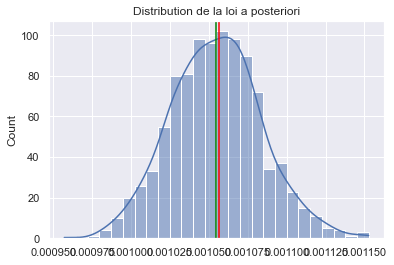

In [76]:
sns.set(style="darkgrid")
sns.histplot(distr, kde=True)
plt.axvline(proba_constante, color='red')
p_esp = sum(distr)/len(distr)
plt.axvline(p_esp, color="green")
plt.title("Distribution de la loi a posteriori")

Text(0.5, 1.0, 'Distribution des probas a priori empiriques')

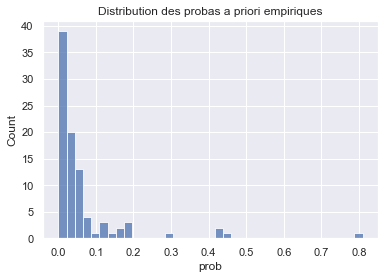

In [78]:
sns.histplot(data['prob'])
plt.title("Distribution des probas a priori empiriques")

## Question 2 : 

On suppose dans un second temps que la probabilité de présence de listeria est variable selon les études.  

Modèle binomial : $r_i \sim \mathcal{B}(n_i,p_i)$ de fdr $f(r_i, p_i) = p_i^{r_i} (1-p_i)^{n_i-r_i}$ 

Loi a priori : $p_i \sim \mathcal{B}eta(\alpha,\beta)$ 

Paramétrisation : $\alpha, \beta$ tels que $\mu = \alpha/(\alpha+\beta) \sim \mathcal{U}([0,1])$ et $\kappa = \alpha + \beta \sim \mathcal{E}(0.1)$


Loi à posteriori : 
> Echantillonnage Metropolis-Within-Gibbs  


In [73]:
sample_kappa = [gen_exp(0.1) for i in range(1000)] 
sample_mu = [rd.random() for i in range(1000)]

<AxesSubplot:ylabel='Count'>

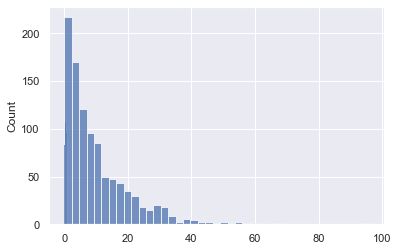